# Chap 09. Diffusion 0.2

----

Conda env : [cv_playgrounds](../../README.md#setup-a-conda-environment)

----

In [5]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
import numpy as np


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

to_pil = transforms.ToPILImage()
def reverse_to_img(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    x = x.cpu()
    return to_pil(x)

def show_images(images, title_msg = None):
    def last_argmin(arr):
        arr_rev = arr[::-1]
        return len(arr_rev) - 1 - np.argmin(arr_rev)

    img_num = len(images)

    col_set = [2, 3, 5]
    x = [img_num % i for i in col_set]
    cols = col_set[last_argmin(x)]
    rows = math.ceil(img_num / cols)

    fig = plt.figure(figsize=(cols, rows))
    for i in range(img_num):
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    if title_msg is not None:
        plt.suptitle(title_msg)
    plt.show()

def _pos_encoding(time_idx, output_dim, device='cpu'):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

def pos_encoding(timesteps, output_dim, device='cpu'):
    batch_size = len(timesteps)
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

class UNet(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, timesteps):
        v = pos_encoding(timesteps, self.time_embed_dim, x.device)

        x1 = self.down1(x, v)
        x = self.maxpool(x1)
        x2 = self.down2(x, v)
        x = self.maxpool(x2)

        x = self.bot1(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, v)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, v)
        x = self.out(x)
        return x


class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t, device = 'cpu'):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x.to(device), t.to(device))
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    def sample(self, model = None, x_shape=(20, 1, 28, 28), step = 1):
        if model is None:
            model = self.model

        device_ = next(model.parameters()).device
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device = device_)

        t_range = list(range(self.num_timesteps, 0, -step)) + [1]
        t_range = sorted(list(set(t_range)), reverse=True)


        for i in tqdm(t_range):
            t = torch.tensor([i] * batch_size, device = device_, dtype=torch.long)
            x = self.denoise(model, x, t, device = device_)

        images = [reverse_to_img(x[i]) for i in range(batch_size)]
        return images


In [6]:
def train(dataset, batch_size,
          diffuser, num_timesteps,
          model, img_ch, img_size, device,
          epochs, lr):

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        loss_sum = 0.0
        cnt = 0

        # generate samples every epoch ===================
        # images = diffuser.sample(model)
        # show_images(images)
        # ================================================

        for images, labels in tqdm(dataloader):
            optimizer.zero_grad()
            x = images.to(device)
            t = torch.randint(1, num_timesteps+1, (len(x),), device=device)

            x_noisy, noise = diffuser.add_noise(x, t)
            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise, noise_pred)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            cnt += 1

        if epoch % 10 == 0:
            test_images = diffuser.sample(model, x_shape = (5, img_ch, img_size, img_size))
            show_images(test_images, f"Epoch {epoch}")

        loss_avg = loss_sum / cnt
        losses.append(loss_avg)
        print(f'Epoch {epoch} | Loss: {loss_avg}')

    # plot losses
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # generate samples
    images = diffuser.sample(model, x_shape = (5, img_ch, img_size, img_size))
    show_images(images, "Test Images")


the size of dataset : 1020
Image shape: torch.Size([3, 128, 128])


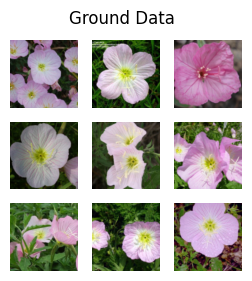

100%|██████████| 1000/1000 [00:22<00:00, 44.88it/s]


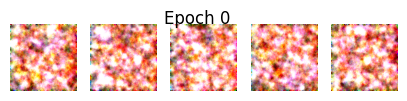

Epoch 0 | Loss: 0.13020479545230046


100%|██████████| 128/128 [00:10<00:00, 12.17it/s]


Epoch 1 | Loss: 0.05177738032944035


100%|██████████| 128/128 [00:10<00:00, 12.52it/s]


Epoch 2 | Loss: 0.03582474977883976


100%|██████████| 128/128 [00:16<00:00,  7.79it/s]


Epoch 3 | Loss: 0.038335633151291404


100%|██████████| 128/128 [00:18<00:00,  6.80it/s]


Epoch 4 | Loss: 0.03893169921502704


100%|██████████| 128/128 [00:10<00:00, 12.35it/s]


Epoch 5 | Loss: 0.032955045251583215


100%|██████████| 128/128 [00:10<00:00, 12.59it/s]


Epoch 6 | Loss: 0.02857076960935956


100%|██████████| 128/128 [00:13<00:00,  9.66it/s]


Epoch 7 | Loss: 0.03293855072115548


100%|██████████| 128/128 [00:10<00:00, 12.24it/s]


Epoch 8 | Loss: 0.0316120869902079


100%|██████████| 128/128 [00:12<00:00, 10.43it/s]


Epoch 9 | Loss: 0.028273309639189392


100%|██████████| 1000/1000 [00:28<00:00, 35.00it/s]


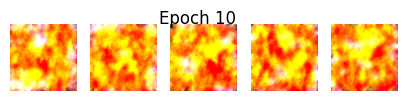

Epoch 10 | Loss: 0.026644190635124687


100%|██████████| 128/128 [00:20<00:00,  6.12it/s]


Epoch 11 | Loss: 0.029306205156899523


100%|██████████| 128/128 [00:21<00:00,  6.07it/s]


Epoch 12 | Loss: 0.0290826143900631


100%|██████████| 128/128 [00:20<00:00,  6.18it/s]


Epoch 13 | Loss: 0.025764721052837558


100%|██████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 14 | Loss: 0.024652717918797862


100%|██████████| 128/128 [00:20<00:00,  6.12it/s]


Epoch 15 | Loss: 0.028347528786980547


100%|██████████| 128/128 [00:20<00:00,  6.11it/s]


Epoch 16 | Loss: 0.024404972878983244


100%|██████████| 128/128 [00:20<00:00,  6.15it/s]


Epoch 17 | Loss: 0.026041742188681383


 48%|████▊     | 61/128 [00:10<00:11,  6.05it/s]


KeyboardInterrupt: 

In [13]:
## Training Flowers102

img_size = 128
batch_size = 8 #128
num_timesteps = 1000
epochs = 100
lr = 1e-3
# -----

preprocess = transforms.Compose([
    transforms.Resize(img_size),  # Resize the image
    transforms.CenterCrop(img_size), # Crop the center
    transforms.ToTensor() # Convert the image to a tensor
])

flower_dataset = torchvision.datasets.Flowers102(root='./temp_data', download=True, transform=preprocess)
print(f"the size of dataset : {len(flower_dataset)}")
print(f"Image shape: {flower_dataset[0][0].shape}")
img_ch = flower_dataset[0][0].shape[0]
img_lst = []
for i in range(9):
    img_lst.append(reverse_to_img(flower_dataset[i][0]))

show_images(img_lst, "Ground Data")

flower_dataloader = DataLoader(flower_dataset, batch_size=batch_size, shuffle=True)
flower_diffuser = Diffuser(num_timesteps, device=device)
flower_model = UNet(in_ch=3)
flower_model.to(device)

train(dataset = flower_dataset, batch_size =  batch_size,
      diffuser = flower_diffuser, num_timesteps =  num_timesteps,
      model = flower_model, img_ch = 3, img_size =  img_size,
      device = device, epochs =  epochs, lr = lr)

100%|██████████| 1000/1000 [00:28<00:00, 35.10it/s]


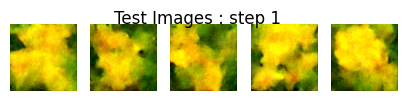

100%|██████████| 501/501 [00:11<00:00, 44.97it/s]


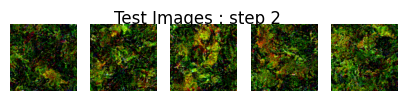

100%|██████████| 334/334 [00:06<00:00, 48.17it/s]


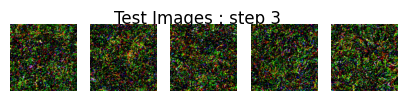

In [ ]:
## Testing Flowers102

for s in [1, 2, 3]:
    images = flower_diffuser.sample(flower_model, x_shape = (5, img_ch, img_size, img_size), step=s)
    show_images(images, f"Test Images : step {s}")

the size of dataset : 60000
Image shape: torch.Size([1, 28, 28])


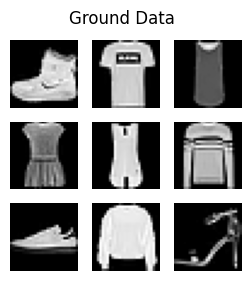

100%|██████████| 1000/1000 [00:10<00:00, 99.41it/s]


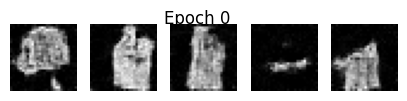

Epoch 0 | Loss: 0.056631643376720234


100%|██████████| 469/469 [00:38<00:00, 12.19it/s]


Epoch 1 | Loss: 0.03651115661665702


100%|██████████| 469/469 [00:40<00:00, 11.64it/s]


Epoch 2 | Loss: 0.033225549257862794


100%|██████████| 469/469 [00:38<00:00, 12.14it/s]


Epoch 3 | Loss: 0.031144690427825902


100%|██████████| 469/469 [00:41<00:00, 11.41it/s]


Epoch 4 | Loss: 0.030062896848868714


100%|██████████| 469/469 [00:44<00:00, 10.46it/s]


Epoch 5 | Loss: 0.02836068240262425


100%|██████████| 469/469 [00:48<00:00,  9.67it/s]


Epoch 6 | Loss: 0.027998114370111463


100%|██████████| 469/469 [00:49<00:00,  9.49it/s]


Epoch 7 | Loss: 0.02712834711228289


100%|██████████| 469/469 [00:47<00:00,  9.94it/s]


Epoch 8 | Loss: 0.026926584249890563


100%|██████████| 469/469 [00:38<00:00, 12.27it/s]


Epoch 9 | Loss: 0.026331880942050582


100%|██████████| 1000/1000 [00:10<00:00, 96.53it/s]


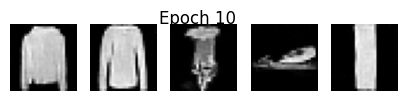

Epoch 10 | Loss: 0.02622449174443923


100%|██████████| 469/469 [00:37<00:00, 12.45it/s]


Epoch 11 | Loss: 0.025847434072193306


100%|██████████| 469/469 [00:38<00:00, 12.07it/s]


Epoch 12 | Loss: 0.025506946172859115


100%|██████████| 469/469 [00:39<00:00, 12.02it/s]


Epoch 13 | Loss: 0.025000202473499246


100%|██████████| 469/469 [00:37<00:00, 12.57it/s]


Epoch 14 | Loss: 0.025075281412203682


100%|██████████| 469/469 [00:37<00:00, 12.61it/s]


Epoch 15 | Loss: 0.024838814436436207


100%|██████████| 469/469 [00:37<00:00, 12.63it/s]


Epoch 16 | Loss: 0.024217187297909754


100%|██████████| 469/469 [00:37<00:00, 12.47it/s]


Epoch 17 | Loss: 0.024486144625349468


100%|██████████| 469/469 [00:41<00:00, 11.24it/s]


Epoch 18 | Loss: 0.024286609260178706


100%|██████████| 469/469 [00:47<00:00,  9.93it/s]


Epoch 19 | Loss: 0.02409983807400282


100%|██████████| 1000/1000 [00:08<00:00, 111.96it/s]


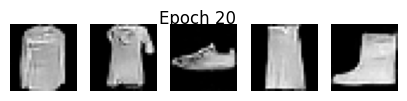

Epoch 20 | Loss: 0.023826204027845535


100%|██████████| 469/469 [00:48<00:00,  9.77it/s]


Epoch 21 | Loss: 0.02366189530560139


100%|██████████| 469/469 [00:47<00:00,  9.80it/s]


Epoch 22 | Loss: 0.023491596207340388


100%|██████████| 469/469 [00:48<00:00,  9.67it/s]


Epoch 23 | Loss: 0.023839095428681324


100%|██████████| 469/469 [00:48<00:00,  9.73it/s]


Epoch 24 | Loss: 0.02338868510653215


100%|██████████| 469/469 [00:47<00:00,  9.82it/s]


Epoch 25 | Loss: 0.02348085117937405


100%|██████████| 469/469 [00:48<00:00,  9.71it/s]


Epoch 26 | Loss: 0.023236592282364365


100%|██████████| 469/469 [00:50<00:00,  9.23it/s]


Epoch 27 | Loss: 0.023241610546260755


100%|██████████| 469/469 [00:48<00:00,  9.59it/s]


Epoch 28 | Loss: 0.023453605297738427


100%|██████████| 469/469 [00:47<00:00,  9.96it/s]


Epoch 29 | Loss: 0.023105537896153768


100%|██████████| 1000/1000 [00:09<00:00, 107.08it/s]


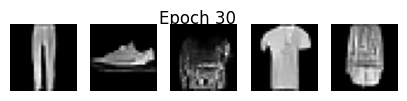

Epoch 30 | Loss: 0.023193366708420614


100%|██████████| 469/469 [00:39<00:00, 11.82it/s]


Epoch 31 | Loss: 0.023042322454183722


100%|██████████| 469/469 [00:47<00:00,  9.94it/s]


Epoch 32 | Loss: 0.023118023705015433


100%|██████████| 469/469 [00:48<00:00,  9.73it/s]


Epoch 33 | Loss: 0.02310963745103843


100%|██████████| 469/469 [00:47<00:00,  9.93it/s]


Epoch 34 | Loss: 0.022864130603622145


100%|██████████| 469/469 [00:47<00:00,  9.96it/s]


Epoch 35 | Loss: 0.023092439058604145


100%|██████████| 469/469 [00:48<00:00,  9.64it/s]


Epoch 36 | Loss: 0.022840096257817643


100%|██████████| 469/469 [00:43<00:00, 10.81it/s]


Epoch 37 | Loss: 0.022459704154875994


100%|██████████| 469/469 [00:37<00:00, 12.50it/s]


Epoch 38 | Loss: 0.02276510989535719


100%|██████████| 469/469 [00:38<00:00, 12.24it/s]


Epoch 39 | Loss: 0.023167964184223844


100%|██████████| 1000/1000 [00:09<00:00, 100.54it/s]


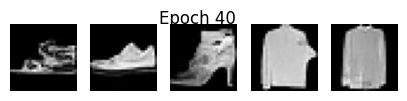

Epoch 40 | Loss: 0.022844445990966453


100%|██████████| 469/469 [00:38<00:00, 12.11it/s]


Epoch 41 | Loss: 0.022487628303452342


100%|██████████| 469/469 [00:38<00:00, 12.21it/s]


Epoch 42 | Loss: 0.02220294205372585


100%|██████████| 469/469 [00:38<00:00, 12.17it/s]


Epoch 43 | Loss: 0.022562730362388626


100%|██████████| 469/469 [00:38<00:00, 12.06it/s]


Epoch 44 | Loss: 0.022539225049507516


100%|██████████| 469/469 [00:38<00:00, 12.06it/s]


Epoch 45 | Loss: 0.0223138866755468


100%|██████████| 469/469 [00:38<00:00, 12.32it/s]


Epoch 46 | Loss: 0.022160748351436815


100%|██████████| 469/469 [00:37<00:00, 12.36it/s]


Epoch 47 | Loss: 0.022348202774916757


100%|██████████| 469/469 [00:37<00:00, 12.44it/s]


Epoch 48 | Loss: 0.02203281680697889


100%|██████████| 469/469 [00:38<00:00, 12.32it/s]


Epoch 49 | Loss: 0.022394930443434574


100%|██████████| 1000/1000 [00:09<00:00, 103.05it/s]


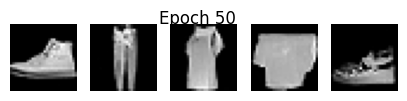

Epoch 50 | Loss: 0.021937205311236604


100%|██████████| 469/469 [00:38<00:00, 12.18it/s]


Epoch 51 | Loss: 0.02205221260240528


100%|██████████| 469/469 [00:38<00:00, 12.14it/s]


Epoch 52 | Loss: 0.02235365195124388


100%|██████████| 469/469 [00:38<00:00, 12.14it/s]


Epoch 53 | Loss: 0.0222459681836495


100%|██████████| 469/469 [00:39<00:00, 11.83it/s]


Epoch 54 | Loss: 0.022017589255945005


100%|██████████| 469/469 [00:39<00:00, 11.96it/s]


Epoch 55 | Loss: 0.022155404194140995


100%|██████████| 469/469 [00:41<00:00, 11.41it/s]


Epoch 56 | Loss: 0.022291884277023867


100%|██████████| 469/469 [00:38<00:00, 12.07it/s]


Epoch 57 | Loss: 0.022378622975224242


100%|██████████| 469/469 [00:38<00:00, 12.11it/s]


Epoch 58 | Loss: 0.022028757165918855


100%|██████████| 469/469 [00:39<00:00, 11.75it/s]


Epoch 59 | Loss: 0.021919224234516307


100%|██████████| 1000/1000 [00:10<00:00, 99.14it/s]


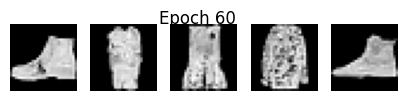

Epoch 60 | Loss: 0.02208256020522448


100%|██████████| 469/469 [00:41<00:00, 11.36it/s]


Epoch 61 | Loss: 0.022298182338984535


100%|██████████| 469/469 [00:38<00:00, 12.13it/s]


Epoch 62 | Loss: 0.021837568101185218


100%|██████████| 469/469 [00:38<00:00, 12.18it/s]


Epoch 63 | Loss: 0.022039407437274068


100%|██████████| 469/469 [00:39<00:00, 11.82it/s]


Epoch 64 | Loss: 0.022160807245178646


100%|██████████| 469/469 [00:39<00:00, 12.00it/s]


Epoch 65 | Loss: 0.021724817797795795


100%|██████████| 469/469 [00:39<00:00, 11.93it/s]


Epoch 66 | Loss: 0.02172155572828263


100%|██████████| 469/469 [00:39<00:00, 11.76it/s]


Epoch 67 | Loss: 0.02238534275950717


100%|██████████| 469/469 [00:38<00:00, 12.14it/s]


Epoch 68 | Loss: 0.021752928389605682


100%|██████████| 469/469 [00:38<00:00, 12.24it/s]


Epoch 69 | Loss: 0.021717200923496598


100%|██████████| 1000/1000 [00:09<00:00, 102.70it/s]


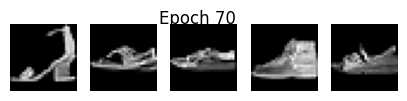

Epoch 70 | Loss: 0.021880254802752786


100%|██████████| 469/469 [00:38<00:00, 12.21it/s]


Epoch 71 | Loss: 0.022347992401260303


100%|██████████| 469/469 [00:38<00:00, 12.26it/s]


Epoch 72 | Loss: 0.022125177532196172


100%|██████████| 469/469 [00:38<00:00, 12.16it/s]


Epoch 73 | Loss: 0.021774617011851467


100%|██████████| 469/469 [00:38<00:00, 12.26it/s]


Epoch 74 | Loss: 0.022018866107137852


100%|██████████| 469/469 [00:39<00:00, 11.87it/s]


Epoch 75 | Loss: 0.021694718772716233


100%|██████████| 469/469 [00:40<00:00, 11.47it/s]


Epoch 76 | Loss: 0.0217943487605497


100%|██████████| 469/469 [00:42<00:00, 11.05it/s]


Epoch 77 | Loss: 0.021749282750223618


100%|██████████| 469/469 [00:39<00:00, 11.96it/s]


Epoch 78 | Loss: 0.021345700838291314


100%|██████████| 469/469 [00:39<00:00, 11.98it/s]


Epoch 79 | Loss: 0.02187905748134483


100%|██████████| 1000/1000 [00:10<00:00, 99.63it/s]


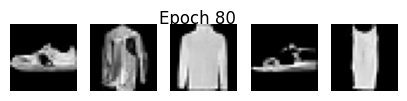

Epoch 80 | Loss: 0.02162335448856674


100%|██████████| 469/469 [00:39<00:00, 12.02it/s]


Epoch 81 | Loss: 0.0219505863732843


100%|██████████| 469/469 [00:40<00:00, 11.58it/s]


Epoch 82 | Loss: 0.021233304425565674


100%|██████████| 469/469 [00:48<00:00,  9.74it/s]


Epoch 83 | Loss: 0.021289994310675017


100%|██████████| 469/469 [00:47<00:00,  9.85it/s]


Epoch 84 | Loss: 0.02172556019096232


100%|██████████| 469/469 [00:48<00:00,  9.65it/s]


Epoch 85 | Loss: 0.021844493314576174


100%|██████████| 469/469 [00:48<00:00,  9.67it/s]


Epoch 86 | Loss: 0.021404066887586864


100%|██████████| 469/469 [00:49<00:00,  9.45it/s]


Epoch 87 | Loss: 0.02173921847537255


100%|██████████| 469/469 [00:45<00:00, 10.34it/s]


Epoch 88 | Loss: 0.021456539263523845


100%|██████████| 469/469 [00:39<00:00, 12.00it/s]


Epoch 89 | Loss: 0.021345578140017193


100%|██████████| 1000/1000 [00:09<00:00, 102.75it/s]


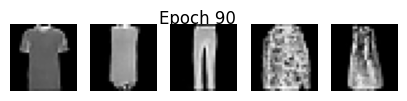

Epoch 90 | Loss: 0.021534428528662938


100%|██████████| 469/469 [00:38<00:00, 12.25it/s]


Epoch 91 | Loss: 0.021410662412786406


100%|██████████| 469/469 [00:38<00:00, 12.29it/s]


Epoch 92 | Loss: 0.021517878142135866


100%|██████████| 469/469 [00:37<00:00, 12.38it/s]


Epoch 93 | Loss: 0.021655755604047384


100%|██████████| 469/469 [00:38<00:00, 12.11it/s]


Epoch 94 | Loss: 0.021570834714466573


100%|██████████| 469/469 [00:38<00:00, 12.09it/s]


Epoch 95 | Loss: 0.021403692893064354


100%|██████████| 469/469 [00:39<00:00, 12.00it/s]


Epoch 96 | Loss: 0.021787764796458962


100%|██████████| 469/469 [00:38<00:00, 12.23it/s]


Epoch 97 | Loss: 0.021566075431719137


100%|██████████| 469/469 [00:41<00:00, 11.40it/s]


Epoch 98 | Loss: 0.021872797687011742


100%|██████████| 469/469 [00:48<00:00,  9.70it/s]


Epoch 99 | Loss: 0.021460488438606262


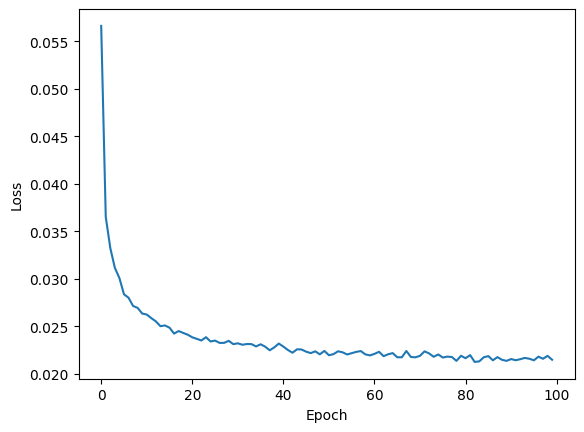

100%|██████████| 1000/1000 [00:09<00:00, 101.80it/s]


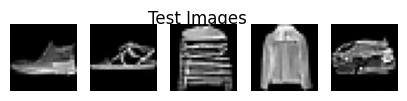

In [9]:
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 100
lr = 1e-3
# -----

preprocess = transforms.Compose([
    transforms.Resize(img_size),  # Resize the image
    transforms.CenterCrop(img_size), # Crop the center
    transforms.ToTensor() # Convert the image to a tensor
])

fashion_dataset = torchvision.datasets.FashionMNIST(root='./temp_data', download=True, transform=preprocess)
print(f"the size of dataset : {len(fashion_dataset)}")
print(f"Image shape: {fashion_dataset[0][0].shape}")
img_ch = fashion_dataset[0][0].shape[0]
img_lst = []
for i in range(9):
    img_lst.append(reverse_to_img(fashion_dataset[i][0]))

show_images(img_lst, "Ground Data")

# fashion_dataloader = DataLoader(fashion_dataset, batch_size=batch_size, shuffle=True)
fashion_diffuser = Diffuser(num_timesteps, device=device)
fashion_model = UNet(in_ch= 1)
fashion_model.to(device)

train(dataset = fashion_dataset, batch_size =  batch_size,
      diffuser = fashion_diffuser, num_timesteps =  num_timesteps,
      model = fashion_model, img_ch = 1, img_size =  img_size,
      device = device, epochs =  epochs, lr = lr)

100%|██████████| 1000/1000 [00:10<00:00, 99.01it/s]


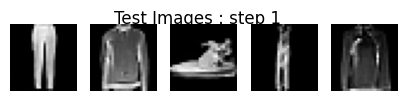

100%|██████████| 501/501 [00:05<00:00, 97.04it/s] 


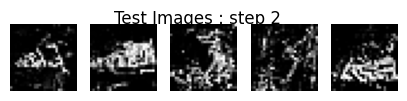

100%|██████████| 334/334 [00:03<00:00, 98.06it/s] 


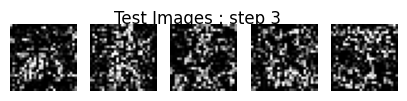

In [10]:

for s in [1, 2, 3]:
    images = fashion_diffuser.sample(fashion_model, x_shape = (5, img_ch, img_size, img_size), step=s)
    show_images(images, f"Test Images : step {s}")